## TODO:
- clean reviews
- consider using: svm, trees, logistic regression for anime quality classification

In [1]:
import os
import math
import itertools
import spacy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import preprocess as prep
import utils_data as ud

from pprint import pprint

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 500)

In [2]:
animes_df = pd.read_hdf("data/mal_synopsis_vectors.hdf5", "table")

In [3]:
# Reorganize relevant components
animes_df.drop("reviews", axis=1, inplace=True)
mal_id = animes_df["mal_id"]
title = animes_df["title_english"]
animes_df.drop(columns=["mal_id", "title_english"], axis=1, inplace=True)
animes_df.insert(0, "mal_id", mal_id)
animes_df.insert(1, "title_english", title)

In [4]:
# Drop rank
animes_df.drop("rank", axis=1, inplace=True)

In [5]:
animes_df.head()

,mal_id,title_english,completed,dropped,favorites,members,on_hold,plan_to_watch,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent,is_Very_Popular,is_Popular,is_Unpopular,is_Very_Unpopular,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,synopsis_vector,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural
0,10030,Bakuman.,173228,2949,1180,227168,5506,37421,136209,227184,8080,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,"[0.05492507, -0.0015817462, -0.023030212, 0.00...",0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0
1,10033,Toriko,27566,9598,739,79840,8156,22607,25609,79849,11922,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,"[-0.06320087, -0.024732614, 0.04239033, -0.118...",1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,10049,Nura: Rise of the Yokai Clan - Demon Capital,78096,1925,586,109049,2952,20868,56856,109074,5233,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,"[0.05399442, 0.02428066, -0.054012954, 0.01463...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,10073,The Qwaser of Stigmata II,58933,4328,108,91658,2717,22014,41283,91658,3666,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,"[-0.07319363, 0.033280805, 0.08378588, 0.10794...",1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
4,10079,A Bridge to the Starry Skies,86865,3594,311,121486,2502,23732,64249,121486,4793,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,"[0.03607239, 0.10807864, -0.17572518, -0.01210...",0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0


## Some notes on preprocessing
The synopsis of each anime are lemmatized and converted into GloVe word embeddings using spaCy. Some keywords are kept after looking at the top 75 most common words, for example, words like "anime", "season", "plot", and "characters" might be important in this domain. Also words that capture sentiments such as "not", "but", "pretty", "love", are also kept. The word embeddings are than averaged to create document embeddings for each synopsis.

The studios of each animes were dropped due to there being a lot of studios to consider and there isn't enough data to justify incorporating studios as features. One mistake I may have made is excluding seasonal animes from 2005 to 2018, that do not have more than 70,000 members (i.e. people who have listed the anime in their profile) and only allowing TV animes (e.g. no OVAs, specials, movies).

From my experience, there are a few handful of staple studios in the anime industry such as KyoAnime, A-1 Pictures, ufotable, and Shaft. Even then, the quality of anime sometimes vary, for example A-1 Pictures have produced quality anime like AnoHana, but also animes like Eromanga (I liked it though). So it isn't as important as core features like genres. I'd include this feature if I had more data.

There are a total of 39 genres, but the top 15 genres plus Shoujo and Jousei were kept. Though technically they aren't genres, they are targetted at certain demographs, just like Shounen and Seinen. It seems to be more useful than the other lower count features.

Most animes are adaptations of mangas or light novels. The source features are categorized as "manga", "light novel". "original", "visual novel", and "other".

After looking at the distribution of scores, I've decided to divide the scores into five categories with respect to their rating. The scores were binned based on quantiles of [0.2, 0.4, 0.8, 0.9]. They seem arbitrary, but the scores are right skewed. The average rating is about a 7.3, which should be then considered "average."

Popularity is also broken up into bins, similar to scores.

Rankings are dropped because it's based on score. Rankings are calculated based on the following [formula](https://myanimelist.net/info.php?go=topanime). So the objective of this notebook is more so inference than classification. 

## A more in-depth look into the features

In [6]:
animes_df.describe()

,mal_id,completed,dropped,favorites,members,on_hold,plan_to_watch,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent,is_Very_Popular,is_Popular,is_Unpopular,is_Very_Unpopular,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural
count,915.000000,9.150000e+02,915.000000,915.000000,9.150000e+02,915.000000,915.000000,9.150000e+02,9.150000e+02,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,18631.746448,1.602196e+05,9536.824044,4146.897268,2.468419e+05,8072.382514,52246.819672,1.265625e+05,2.468562e+05,16780.510383,0.306011,0.274317,0.224044,0.195628,0.029508,0.039344,0.042623,0.059016,0.046995,0.055738,0.073224,0.080874,0.090710,0.116940,0.095082,0.100546,0.096175,0.073224,0.201093,0.202186,0.397814,0.100546,0.098361,0.248087,0.250273,0.252459,0.249180,0.269945,0.449180,0.224044,0.440437,0.131148,0.069945,0.410929,0.142077,0.498361,0.246995,0.148634,0.262295,0.132240,0.021858,0.130055,0.350820,0.322404,0.159563,0.136612,0.059016,0.226230,0.184699,0.269945
std,11982.255931,1.711732e+05,8415.332578,10162.148285,2.189061e+05,8210.564680,34312.296403,1.361623e+05,2.189183e+05,21544.223562,0.461086,0.446413,0.417179,0.396901,0.169319,0.194519,0.202116,0.235784,0.211743,0.229540,0.260646,0.272791,0.287354,0.321524,0.293489,0.300892,0.294992,0.260646,0.401037,0.401850,0.489714,0.300892,0.297965,0.432139,0.433407,0.434661,0.432775,0.444174,0.497683,0.417179,0.496711,0.337746,0.255194,0.492271,0.349320,0.500271,0.431499,0.355922,0.440123,0.338937,0.146300,0.336548,0.477488,0.467652,0.366400,0.343625,0.235784,0.418618,0.388266,0.444174
min,15.000000,1.000000e+00,725.000000,77.000000,7.027000e+04,991.000000,5793.000000,1.763500e+04,7.027000e+04,1630.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7746.500000,5.671000e+04,4529.500000,478.000000,1.072745e+05,3745.500000,28332.500000,4.557700e+04,1.072720e+05,6472.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,18115.000000,1.004310e+05,7322.000000,1131.000000,1.693020e+05,5581.000000,41864.000000,7.913200e+04,1.693020e+05,10244.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [7]:
min_completed = animes_df["completed"].sort_values()[:5]
idx = min_completed.keys()
print(min_completed)

627        1
733        2
686        4
629        4
696    18968
Name: completed, dtype: int64


In [8]:
animes_df.iloc[idx]

,mal_id,title_english,completed,dropped,favorites,members,on_hold,plan_to_watch,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent,is_Very_Popular,is_Popular,is_Unpopular,is_Very_Unpopular,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,synopsis_vector,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural
627,34566,Boruto: Naruto Next Generations,1,35716,2756,288816,30666,41164,111995,288873,181326,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,"[0.021947488, 0.04393465, -0.021062646, -0.032...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
733,37991,JoJo`s Bizarre Adventure: Golden Wind,2,1641,3824,153112,3556,37754,45769,153138,110185,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,"[-0.028252449, 0.055085827, 0.012531352, 0.035...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
686,35972,Fairy Tail Final Series,4,2946,2483,157341,4579,65199,30896,157405,84677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,"[-0.007364329, 0.052913103, -0.051800165, 0.00...",1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
629,34572,Black Clover,4,47270,4679,354945,22761,75446,125635,354962,209481,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,"[-0.028056385, 0.06826307, 0.007837369, -0.005...",1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
696,36432,A Certain Magical Index III,18968,3667,493,102307,3644,49029,19736,102323,27015,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,"[-0.0108009195, -0.0032311669, 0.0087866625, 0...",1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


There is a huge discrepancy between the number of people who have completed these animes. Upon closer inspection, these animes are currently still airing  as of May 2019.

In [9]:
min_members = animes_df["members"].sort_values(ascending=False)
idx = min_members.keys()[:5]
print(min_members[:5])

140    1684324
178    1569373
60     1504178
777    1427864
455    1275985
Name: members, dtype: int64


In [10]:
animes_df.iloc[idx]

,mal_id,title_english,completed,dropped,favorites,members,on_hold,plan_to_watch,scored_by,total,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent,is_Very_Popular,is_Popular,is_Unpopular,is_Very_Unpopular,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,synopsis_vector,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural
140,1535,Death Note,1401867,54998,99761,1684324,51374,104524,1152074,1684431,71668,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,"[-0.09916222, 0.1042756, -0.1009365, 0.0056355...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
178,16498,Attack on Titan,1346675,34495,73150,1569373,26671,74785,1079911,1569557,86931,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,"[-0.066830486, -0.021153145, -0.05448076, 0.03...",1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0
60,11757,Sword Art Online,1299600,59618,54657,1504178,18589,70435,1045947,1504178,55936,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,"[-0.0417105, -0.019505387, -0.06542384, -0.074...",1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
777,5114,Fullmetal Alchemist: Brotherhood,1048492,19302,125990,1427864,50714,201689,867978,1428204,108007,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,"[-0.042600017, 0.06929404, -0.0473744, 0.01969...",1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0
455,30276,One Punch Man,1091856,15980,38574,1275985,19069,82476,857945,1275955,66574,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,"[0.0015818091, 0.049827304, -0.06753425, 0.026...",1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1


In [11]:
stats = ["completed", "dropped", "favorites", "members",
         "on_hold", "plan_to_watch", "scored_by", "total", "watching"]

animes_df[stats].corr()

,completed,dropped,favorites,members,on_hold,plan_to_watch,scored_by,total,watching
completed,1.000000,0.529646,0.770279,0.979257,0.604480,0.677715,0.996695,0.979258,0.488763
dropped,0.529646,1.000000,0.499590,0.624363,0.812035,0.476718,0.569417,0.624352,0.676802
favorites,0.770279,0.499590,1.000000,0.804548,0.704993,0.648630,0.797835,0.804536,0.558290
members,0.979257,0.624363,0.804548,1.000000,0.729091,0.782243,0.987736,1.000000,0.613375
on_hold,0.604480,0.812035,0.704993,0.729091,1.000000,0.735090,0.646012,0.729079,0.736685
plan_to_watch,0.677715,0.476718,0.648630,0.782243,0.735090,1.000000,0.692260,0.782242,0.505050
scored_by,0.996695,0.569417,0.797835,0.987736,0.646012,0.692260,1.000000,0.987735,0.546635
total,0.979258,0.624352,0.804536,1.000000,0.729079,0.782242,0.987735,1.000000,0.613383
watching,0.488763,0.676802,0.558290,0.613375,0.736685,0.505050,0.546635,0.613383,1.000000


`completed` and `members` and `scored_by` are practically the same thing as well since you're a member if you've completed or are watching an anime, and users usually score an anime when they've completed it. I'm guessing `members` = `completed` + `dropped` + `on_hold` + `watching` + `plan_to_watch`. There's also `total` which has a correlation of 1 with `members`.

In [12]:
mem_count = animes_df["members"]
pred_mem_count = animes_df["completed"] + animes_df["dropped"] + animes_df["on_hold"] + animes_df["watching"] + animes_df["plan_to_watch"]
total_count = animes_df["total"]
print(mem_count[:10] - pred_mem_count[:10])
print(total_count[:10] - pred_mem_count[:10])

0    -16
1     -9
2    -25
3      0
4      0
5    -21
6    131
7    -10
8    -58
9    -15
dtype: int64
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64


In [13]:
animes_df[stats].corr()

,completed,dropped,favorites,members,on_hold,plan_to_watch,scored_by,total,watching
completed,1.000000,0.529646,0.770279,0.979257,0.604480,0.677715,0.996695,0.979258,0.488763
dropped,0.529646,1.000000,0.499590,0.624363,0.812035,0.476718,0.569417,0.624352,0.676802
favorites,0.770279,0.499590,1.000000,0.804548,0.704993,0.648630,0.797835,0.804536,0.558290
members,0.979257,0.624363,0.804548,1.000000,0.729091,0.782243,0.987736,1.000000,0.613375
on_hold,0.604480,0.812035,0.704993,0.729091,1.000000,0.735090,0.646012,0.729079,0.736685
plan_to_watch,0.677715,0.476718,0.648630,0.782243,0.735090,1.000000,0.692260,0.782242,0.505050
scored_by,0.996695,0.569417,0.797835,0.987736,0.646012,0.692260,1.000000,0.987735,0.546635
total,0.979258,0.624352,0.804536,1.000000,0.729079,0.782242,0.987735,1.000000,0.613383
watching,0.488763,0.676802,0.558290,0.613375,0.736685,0.505050,0.546635,0.613383,1.000000


Looks like it's `total`. I'm not too sure what `members` is then.

Dropping both will be a good idea since they're almost the same and are a summation of features we already have.

In [14]:
animes_df.drop(columns=["members", "total"], axis=1, inplace=True)

In [15]:
stats = ["completed", "dropped", "favorites",
         "on_hold", "plan_to_watch", "scored_by",
         "watching"]

animes_df[stats].corr()

,completed,dropped,favorites,on_hold,plan_to_watch,scored_by,watching
completed,1.000000,0.529646,0.770279,0.604480,0.677715,0.996695,0.488763
dropped,0.529646,1.000000,0.499590,0.812035,0.476718,0.569417,0.676802
favorites,0.770279,0.499590,1.000000,0.704993,0.648630,0.797835,0.558290
on_hold,0.604480,0.812035,0.704993,1.000000,0.735090,0.646012,0.736685
plan_to_watch,0.677715,0.476718,0.648630,0.735090,1.000000,0.692260,0.505050
scored_by,0.996695,0.569417,0.797835,0.646012,0.692260,1.000000,0.546635
watching,0.488763,0.676802,0.558290,0.736685,0.505050,0.546635,1.000000


Looking at just the correlation matrix seems to be better. But the correlation matrix only captures pairwise relations, hence I'll also use VIF.

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
stats = ["completed", "dropped", "favorites",
         "on_hold", "plan_to_watch", "scored_by",
         "watching"]

for i in range(len(stats)):
    vif = variance_inflation_factor(animes_df[stats].values, i)
    print("VIF of", stats[i], "is", vif)

VIF of completed is 1395.628408447928
VIF of dropped is 8.391907242187324
VIF of favorites is 6.548741712570463
VIF of on_hold is 14.152462154884834
VIF of plan_to_watch is 6.734916586847818
VIF of scored_by is 1620.2245227269805
VIF of watching is 8.489974630814707


Looks like I should drop `completed` and `scored_by` based on the incredibly high VIF. Which again, makes sense since users complete an anime, they'll probably also score it. 

Unexpectedly, `on_hold` has a high VIF as well. I'm going to drop that as well, but I MAY add it back. It might be useful since if an anime is on hold, the anime probably failed to grab the audience's attention at the time. Then again, there are some people (like me) who have a bunch of animes indefinitely on hold but still like the series.

In [17]:
stats = ["dropped", "favorites", "plan_to_watch", "watching"]

animes_df.drop(columns=["completed", "scored_by", "on_hold"], axis=1, inplace=True)

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
stats = ["dropped", "favorites",
          "plan_to_watch",
         "watching"]

for i in range(len(stats)):
    vif = variance_inflation_factor(animes_df[stats].values, i)
    print("VIF of", stats[i], "is", vif)

VIF of dropped is 4.040137641131881
VIF of favorites is 1.9134230849678922
VIF of plan_to_watch is 3.2402398810811275
VIF of watching is 3.410947492414311


In [19]:
# Unroll the word vectors for each row.
unrolled = animes_df.apply(prep.unroll_document_vector, 
                           args=("synopsis_vector",),
                           axis=1, result_type="expand")
unrolled = unrolled.add_prefix("sv_")
animes_df = animes_df.join(unrolled, how="right")
animes_df.drop(columns=["synopsis_vector"], axis=1, inplace=True)

In [20]:
animes_df.head()

,mal_id,title_english,dropped,favorites,plan_to_watch,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent,is_Very_Popular,is_Popular,is_Unpopular,is_Very_Unpopular,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,sv_0,sv_1,sv_2,sv_3,sv_4,sv_5,sv_6,sv_7,sv_8,sv_9,sv_10,sv_11,sv_12,sv_13,sv_14,sv_15,sv_16,sv_17,sv_18,sv_19,sv_20,sv_21,sv_22,sv_23,sv_24,sv_25,sv_26,sv_27,sv_28,sv_29,sv_30,sv_31,sv_32,sv_33,sv_34,sv_35,sv_36,sv_37,sv_38,sv_39,sv_40,sv_41,sv_42,sv_43,sv_44,sv_45,sv_46,sv_47,sv_48,sv_49,sv_50,sv_51,sv_52,sv_53,sv_54,sv_55,sv_56,sv_57,sv_58,sv_59,sv_60,sv_61,sv_62,sv_63,sv_64,sv_65,sv_66,sv_67,sv_68,sv_69,sv_70,sv_71,sv_72,sv_73,sv_74,sv_75,sv_76,sv_77,sv_78,sv_79,sv_80,sv_81,sv_82,sv_83,sv_84,sv_85,sv_86,sv_87,sv_88,sv_89,sv_90,sv_91,sv_92,sv_93,sv_94,sv_95,sv_96,sv_97,sv_98,sv_99,sv_100,sv_101,sv_102,sv_103,sv_104,sv_105,sv_106,sv_107,sv_108,sv_109,sv_110,sv_111,sv_112,sv_113,sv_114,sv_115,sv_116,sv_117,sv_118,sv_119,sv_120,sv_121,sv_122,sv_123,sv_124,sv_125,sv_126,sv_127,sv_128,sv_129,sv_130,sv_131,sv_132,sv_133,sv_134,sv_135,sv_136,sv_137,sv_138,sv_139,sv_140,sv_141,sv_142,sv_143,sv_144,sv_145,sv_146,sv_147,sv_148,sv_149,sv_150,sv_151,sv_152,sv_153,sv_154,sv_155,sv_156,sv_157,sv_158,sv_159,sv_160,sv_161,sv_162,sv_163,sv_164,sv_165,sv_166,sv_167,sv_168,sv_169,sv_170,sv_171,sv_172,sv_173,sv_174,sv_175,sv_176,sv_177,sv_178,sv_179,sv_180,sv_181,sv_182,sv_183,sv_184,sv_185,sv_186,sv_187,sv_188,sv_189,sv_190,sv_191,sv_192,sv_193,sv_194,sv_195,sv_196,sv_197,sv_198,sv_199,sv_200,sv_201,sv_202,sv_203,sv_204,sv_205,sv_206,sv_207,sv_208,sv_209,sv_210,sv_211,sv_212,sv_213,sv_214,sv_215,sv_216,sv_217,sv_218,sv_219,sv_220,sv_221,sv_222,sv_223,sv_224,sv_225,sv_226,sv_227,sv_228,sv_229,sv_230,sv_231,sv_232,sv_233,sv_234,sv_235,sv_236,sv_237,sv_238,sv_239,sv_240,sv_241,sv_242,sv_243,sv_244,sv_245,sv_246,sv_247,sv_248,sv_249,sv_250,sv_251,sv_252,sv_253,sv_254,sv_255,sv_256,sv_257,sv_258,sv_259,sv_260,sv_261,sv_262,sv_263,sv_264,sv_265,sv_266,sv_267,sv_268,sv_269,sv_270,sv_271,sv_272,sv_273,sv_274,sv_275,sv_276,sv_277,sv_278,sv_279,sv_280,sv_281,sv_282,sv_283,sv_284,sv_285,sv_286,sv_287,sv_288,sv_289,sv_290,sv_291,sv_292,sv_293,sv_294,sv_295,sv_296,sv_297,sv_298,sv_299
0,10030,Bakuman.,2949,1180,37421,8080,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0.054925,-0.001582,-0.023030,0.001837,-0.058916,0.020767,0.103268,-0.044993,-0.042293,1.363392,-0.005530,-0.061722,-0.103710,0.065830,0.038575,-0.049531,-0.023129,0.415847,0.019551,0.021869,0.065710,-0.138968,-0.040891,-0.143934,-0.006822,0.118222,0.006989,-0.123293,-0.001545,0.007006,0.005578,-0.040835,0.001453,-0.169356,0.074480,-0.088319,0.006837,-0.014429,0.022495,-0.100941,-0.029592,0.004229,0.015136,0.010769,-0.053390,-0.011896,0.052364,0.030738,-0.000194,-0.092781,0.010464,-0.053027,-0.077989,-0.054796,-0.035145,0.040334,0.060026,0.024201,-0.006362,-0.136720,-0.086299,-0.104930,-0.051046,-0.082023,0.063074,-0.019057,-0.034008,-0.032554,0.088011,-0.027442,0.029546,-0.044004,-0.119241,0.023618,-0.107424,0.006651,-0.089624,-0.058264,0.016375,0.154083,-0.005231,-0.014458,-0.075440,0.089041,-0.031919,-0.008177,-0.003568,-0.059995,-0.006662,-0.051673,-0.196045,-0.063909,-0.084527,0.066443,0.026021,-0.055525,0.059830,0.004648,-0.081881,0.065485,0.039643,-0.096733,-0.076950,-0.060712,0.038362,-0.810380,-0.024446,0.008528,0.055984,0.004946,0.024377,0.010949,0.020298,-0.081651,-0.052472,0.034252,-0.024716,0.074297,0.040505,0.012580,-0.032099,-0.040293,-0.001303,0.012879,0.199188,0.207073,-0.056438,0.029493,-0.0277

## Splitting
I probably should have separated the data into training and testing at the very beginning, but I don't think I've done any major transformations on the data that is heavily reliant on the training data, so hopefully not much bias has been introduced.

In [21]:
from sklearn.model_selection import train_test_split

# Split features and labels
rating_names = ["is_Poor", "is_Below_Average", "is_Average", "is_Above_Average", "is_Excellent"]
ratings = animes_df[rating_names]
animes_df.drop(columns=rating_names, axis=1, inplace=True)

In [22]:
# Split into 75% train, 25% test
train_X, test_X, train_Y, test_Y = train_test_split(animes_df, ratings, random_state=1)

# Avoid chaining
train_X = train_X.copy()
train_Y = train_Y.copy()
test_X = test_X.copy()
ttest_Y = test_Y.copy()

In [23]:
train_X.head()

,mal_id,title_english,dropped,favorites,plan_to_watch,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_Very_Popular,is_Popular,is_Unpopular,is_Very_Unpopular,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,sv_0,sv_1,sv_2,sv_3,sv_4,sv_5,sv_6,sv_7,sv_8,sv_9,sv_10,sv_11,sv_12,sv_13,sv_14,sv_15,sv_16,sv_17,sv_18,sv_19,sv_20,sv_21,sv_22,sv_23,sv_24,sv_25,sv_26,sv_27,sv_28,sv_29,sv_30,sv_31,sv_32,sv_33,sv_34,sv_35,sv_36,sv_37,sv_38,sv_39,sv_40,sv_41,sv_42,sv_43,sv_44,sv_45,sv_46,sv_47,sv_48,sv_49,sv_50,sv_51,sv_52,sv_53,sv_54,sv_55,sv_56,sv_57,sv_58,sv_59,sv_60,sv_61,sv_62,sv_63,sv_64,sv_65,sv_66,sv_67,sv_68,sv_69,sv_70,sv_71,sv_72,sv_73,sv_74,sv_75,sv_76,sv_77,sv_78,sv_79,sv_80,sv_81,sv_82,sv_83,sv_84,sv_85,sv_86,sv_87,sv_88,sv_89,sv_90,sv_91,sv_92,sv_93,sv_94,sv_95,sv_96,sv_97,sv_98,sv_99,sv_100,sv_101,sv_102,sv_103,sv_104,sv_105,sv_106,sv_107,sv_108,sv_109,sv_110,sv_111,sv_112,sv_113,sv_114,sv_115,sv_116,sv_117,sv_118,sv_119,sv_120,sv_121,sv_122,sv_123,sv_124,sv_125,sv_126,sv_127,sv_128,sv_129,sv_130,sv_131,sv_132,sv_133,sv_134,sv_135,sv_136,sv_137,sv_138,sv_139,sv_140,sv_141,sv_142,sv_143,sv_144,sv_145,sv_146,sv_147,sv_148,sv_149,sv_150,sv_151,sv_152,sv_153,sv_154,sv_155,sv_156,sv_157,sv_158,sv_159,sv_160,sv_161,sv_162,sv_163,sv_164,sv_165,sv_166,sv_167,sv_168,sv_169,sv_170,sv_171,sv_172,sv_173,sv_174,sv_175,sv_176,sv_177,sv_178,sv_179,sv_180,sv_181,sv_182,sv_183,sv_184,sv_185,sv_186,sv_187,sv_188,sv_189,sv_190,sv_191,sv_192,sv_193,sv_194,sv_195,sv_196,sv_197,sv_198,sv_199,sv_200,sv_201,sv_202,sv_203,sv_204,sv_205,sv_206,sv_207,sv_208,sv_209,sv_210,sv_211,sv_212,sv_213,sv_214,sv_215,sv_216,sv_217,sv_218,sv_219,sv_220,sv_221,sv_222,sv_223,sv_224,sv_225,sv_226,sv_227,sv_228,sv_229,sv_230,sv_231,sv_232,sv_233,sv_234,sv_235,sv_236,sv_237,sv_238,sv_239,sv_240,sv_241,sv_242,sv_243,sv_244,sv_245,sv_246,sv_247,sv_248,sv_249,sv_250,sv_251,sv_252,sv_253,sv_254,sv_255,sv_256,sv_257,sv_258,sv_259,sv_260,sv_261,sv_262,sv_263,sv_264,sv_265,sv_266,sv_267,sv_268,sv_269,sv_270,sv_271,sv_272,sv_273,sv_274,sv_275,sv_276,sv_277,sv_278,sv_279,sv_280,sv_281,sv_282,sv_283,sv_284,sv_285,sv_286,sv_287,sv_288,sv_289,sv_290,sv_291,sv_292,sv_293,sv_294,sv_295,sv_296,sv_297,sv_298,sv_299
790,5630,Eden of The East,7509,3871,111941,14124,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,-0.049758,0.070097,-0.013160,0.029296,-0.044146,-0.044970,-0.055462,-0.023865,-0.003372,2.051685,-0.020228,-0.062936,-0.058681,-0.017387,-0.049538,0.010696,-0.042397,0.617382,-0.002686,0.032320,-0.018845,-0.044057,-0.024150,0.020822,0.002409,0.045144,0.041674,-0.032702,-0.009256,0.032120,-0.046420,-0.033880,-0.108927,0.011874,0.041124,0.044727,0.086923,0.000375,0.020178,0.002146,0.012383,-0.082690,0.125003,0.057947,-0.035477,0.053562,-0.066956,0.008789,0.026393,-0.055111,-0.094816,-0.000699,-0.090763,-0.048135,-0.054672,0.042932,0.019006,-0.103644,0.069593,-0.074405,-0.002536,-0.075918,0.020236,-0.134388,0.036675,-0.059457,-0.056521,0.088512,0.037646,0.011802,0.010475,-0.021126,0.013673,-0.025007,0.023995,-0.058334,0.038847,-0.115593,-0.011587,0.172999,0.019613,0.038611,-0.122097,-0.004023,0.039357,-0.131059,0.106670,-0.182603,0.019326,0.028611,-0.086143,0.122741,-0.144791,-0.003019,-0.014749,-0.042550,0.010953,-0.084592,-0.058311,0.043956,-0.026148,0.030212,0.020539,-0.070896,0.073315,-0.964839,-0.101054,0.114312,0.027857,0.059342,0.116553,0.025719,-0.004239,-0.077048,-0.053274,0.072610,0.050920,0.103574,-0.000879,-0.013368,-0.045377,-0.056739,0.009959,0.031102,0.121459,0.057266,-0.022258,-0.017304,-0.027942,0.038878,0.013859,-0.022585,0.033855,0.076539,0.006868,-0.007856,-

In [24]:
train_X.describe()

,mal_id,dropped,favorites,plan_to_watch,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_Very_Popular,is_Popular,is_Unpopular,is_Very_Unpopular,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,sv_0,sv_1,sv_2,sv_3,sv_4,sv_5,sv_6,sv_7,sv_8,sv_9,sv_10,sv_11,sv_12,sv_13,sv_14,sv_15,sv_16,sv_17,sv_18,sv_19,sv_20,sv_21,sv_22,sv_23,sv_24,sv_25,sv_26,sv_27,sv_28,sv_29,sv_30,sv_31,sv_32,sv_33,sv_34,sv_35,sv_36,sv_37,sv_38,sv_39,sv_40,sv_41,sv_42,sv_43,sv_44,sv_45,sv_46,sv_47,sv_48,sv_49,sv_50,sv_51,sv_52,sv_53,sv_54,sv_55,sv_56,sv_57,sv_58,sv_59,sv_60,sv_61,sv_62,sv_63,sv_64,sv_65,sv_66,sv_67,sv_68,sv_69,sv_70,sv_71,sv_72,sv_73,sv_74,sv_75,sv_76,sv_77,sv_78,sv_79,sv_80,sv_81,sv_82,sv_83,sv_84,sv_85,sv_86,sv_87,sv_88,sv_89,sv_90,sv_91,sv_92,sv_93,sv_94,sv_95,sv_96,sv_97,sv_98,sv_99,sv_100,sv_101,sv_102,sv_103,sv_104,sv_105,sv_106,sv_107,sv_108,sv_109,sv_110,sv_111,sv_112,sv_113,sv_114,sv_115,sv_116,sv_117,sv_118,sv_119,sv_120,sv_121,sv_122,sv_123,sv_124,sv_125,sv_126,sv_127,sv_128,sv_129,sv_130,sv_131,sv_132,sv_133,sv_134,sv_135,sv_136,sv_137,sv_138,sv_139,sv_140,sv_141,sv_142,sv_143,sv_144,sv_145,sv_146,sv_147,sv_148,sv_149,sv_150,sv_151,sv_152,sv_153,sv_154,sv_155,sv_156,sv_157,sv_158,sv_159,sv_160,sv_161,sv_162,sv_163,sv_164,sv_165,sv_166,sv_167,sv_168,sv_169,sv_170,sv_171,sv_172,sv_173,sv_174,sv_175,sv_176,sv_177,sv_178,sv_179,sv_180,sv_181,sv_182,sv_183,sv_184,sv_185,sv_186,sv_187,sv_188,sv_189,sv_190,sv_191,sv_192,sv_193,sv_194,sv_195,sv_196,sv_197,sv_198,sv_199,sv_200,sv_201,sv_202,sv_203,sv_204,sv_205,sv_206,sv_207,sv_208,sv_209,sv_210,sv_211,sv_212,sv_213,sv_214,sv_215,sv_216,sv_217,sv_218,sv_219,sv_220,sv_221,sv_222,sv_223,sv_224,sv_225,sv_226,sv_227,sv_228,sv_229,sv_230,sv_231,sv_232,sv_233,sv_234,sv_235,sv_236,sv_237,sv_238,sv_239,sv_240,sv_241,sv_242,sv_243,sv_244,sv_245,sv_246,sv_247,sv_248,sv_249,sv_250,sv_251,sv_252,sv_253,sv_254,sv_255,sv_256,sv_257,sv_258,sv_259,sv_260,sv_261,sv_262,sv_263,sv_264,sv_265,sv_266,sv_267,sv_268,sv_269,sv_270,sv_271,sv_272,sv_273,sv_274,sv_275,sv_276,sv_277,sv_278,sv_279,sv_280,sv_281,sv_282,sv_283,sv_284,sv_285,sv_286,sv_287,sv_288,sv_289,sv_290,sv_291,sv_292,sv_293,sv_294,sv_295,sv_296,sv_297,sv_298,sv_299
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.00000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.00000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.00000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.

In [25]:
train_Y.head()

,is_Poor,is_Below_Average,is_Average,is_Above_Average,is_Excellent
790,0,0,1,0,0
185,0,1,0,0,0
363,0,0,0,1,0
888,0,0,0,0,1
531,1,0,0,0,0


## Standardizing
Looking at some of the distributions.

Text(0,0.5,'Number of animes')

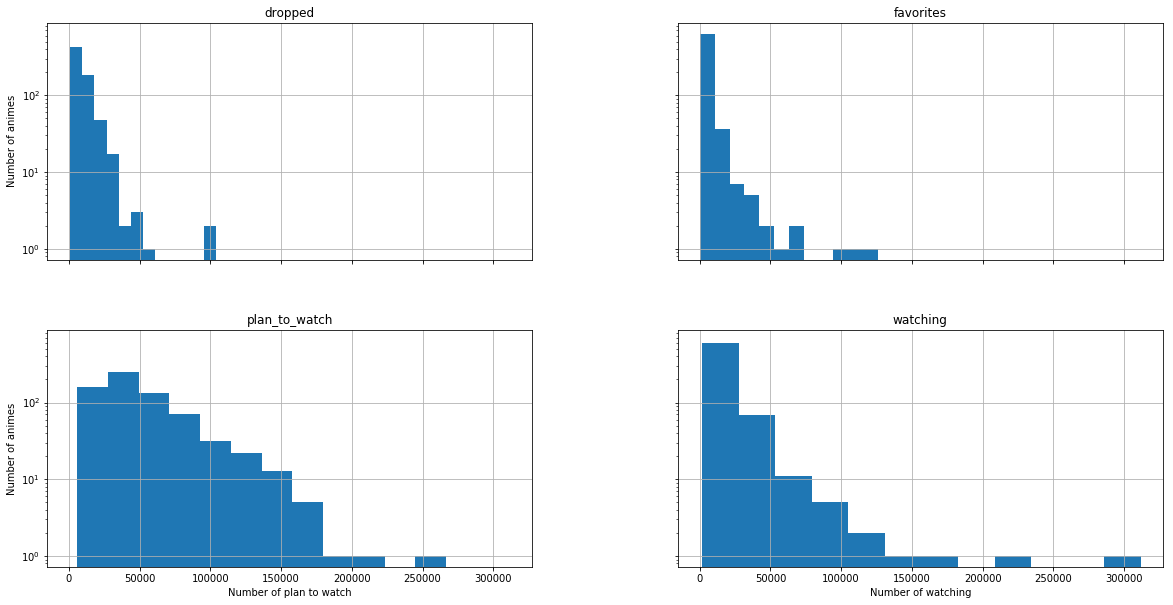

In [26]:
stats = ["dropped", "favorites", "watching", "plan_to_watch"]

axes = train_X.hist(column=["dropped", "favorites", "watching", "plan_to_watch"],
                    figsize=(20,10), bins=12, log=True, sharex=True, sharey=True)
axes = axes.flatten()
axes[0].set_xlabel("Number of dropped")
axes[0].set_ylabel("Number of animes")

axes[1].set_xlabel("Number of favorites")
axes[1].set_ylabel("Number of animes")

axes[2].set_xlabel("Number of plan to watch")
axes[2].set_ylabel("Number of animes")

axes[3].set_xlabel("Number of watching")
axes[3].set_ylabel("Number of animes")

They're very left skewed, so standardizing with mean and variance is a bad idea.

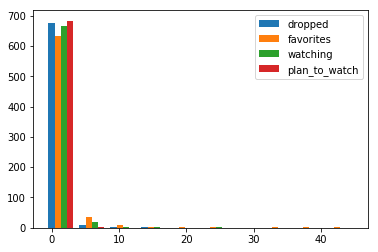

In [27]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
scaled_stats = robust_scaler.fit_transform(train_X[stats])

fig, ax = plt.subplots(1,1)
plt.hist([x for x in scaled_stats.T], label=stats)
ax.legend()

Looks like robust scaling won't help out much. This is expected since the above histograms are incredibly skewed.

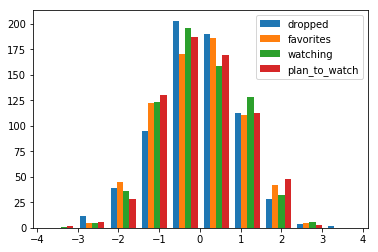

In [28]:
from sklearn.preprocessing import PowerTransformer

power_transformer = PowerTransformer(method="box-cox")
transformed_stats = power_transformer.fit_transform(train_X[stats])

fig, ax = plt.subplots(1,1)
plt.hist([x for x in transformed_stats.T], label=stats)
ax.legend()

That's a lot better! Using a box cox transform makes it more gaussian like, which is crucial for whitening.

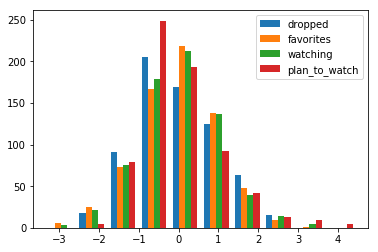

In [29]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True)
whitened_stats = pca.fit_transform(transformed_stats)

fig, ax = plt.subplots(1,1)
plt.hist([x for x in whitened_stats.T], label=stats)
ax.legend()

In [30]:
ws_df = pd.DataFrame({
    "dropped": whitened_stats[:,0],
    "favorites": whitened_stats[:,1],
    "plan_to_watch": whitened_stats[:,2],
    "watching": whitened_stats[:,3],
})

In [41]:
ws_df.describe()

,dropped,favorites,plan_to_watch,watching
count,229.000000,229.000000,229.000000,229.000000
mean,0.011690,0.109580,-0.043290,0.074792
std,1.049825,0.998742,1.042543,1.082558
min,-2.770153,-3.052746,-3.708196,-2.474342
25%,-0.748461,-0.423405,-0.615821,-0.629890
50%,-0.068612,0.173447,-0.042232,-0.182476
75%,0.658729,0.772939,0.594357,0.580845
max,2.441441,2.459434,2.789199,4.719956


In [40]:
ws_df.corr()

,dropped,favorites,plan_to_watch,watching
dropped,1.000000,0.051137,-0.107057,0.039209
favorites,0.051137,1.000000,0.003619,0.142871
plan_to_watch,-0.107057,0.003619,1.000000,-0.166328
watching,0.039209,0.142871,-0.166328,1.000000


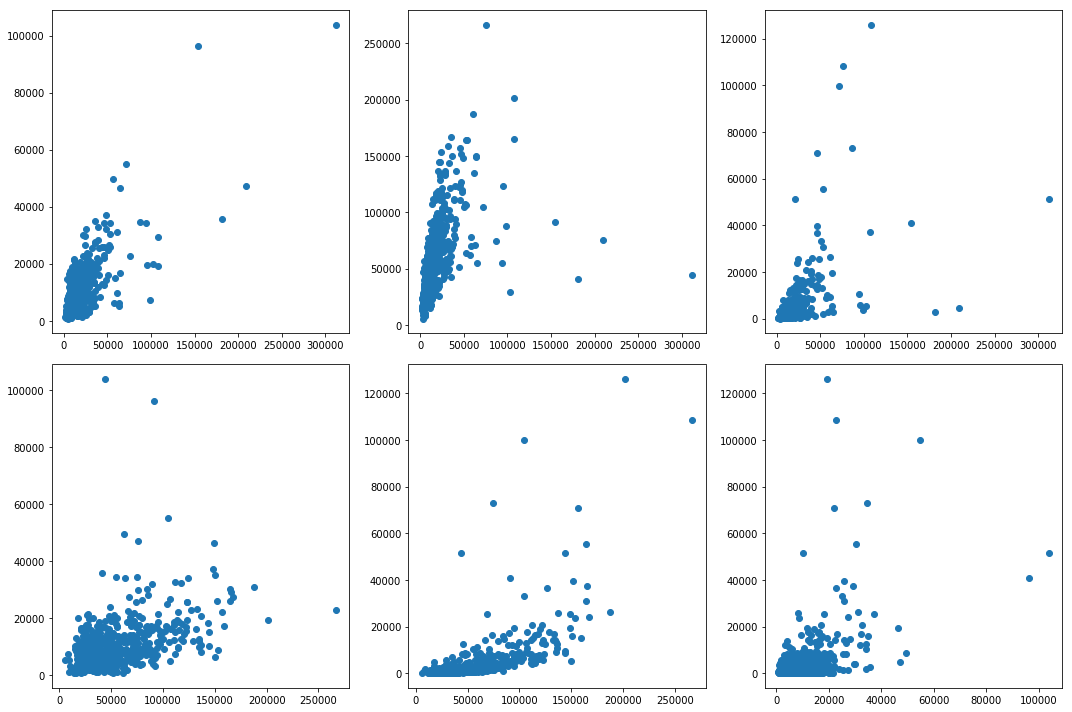

In [31]:
fig, ax = plt.subplots(2,3)
fig.set_figwidth(15)
fig.set_figheight(10)

plt.subplot(2,3,1)
plt.scatter(train_X["watching"], train_X["dropped"])
plt.subplot(2,3,2)
plt.scatter(train_X["watching"], train_X["plan_to_watch"])
plt.subplot(2,3,3)
plt.scatter(train_X["watching"], train_X["favorites"])
plt.subplot(2,3,4)
plt.scatter(train_X["plan_to_watch"], train_X["dropped"])
plt.subplot(2,3,5)
plt.scatter(train_X["plan_to_watch"], train_X["favorites"])
plt.subplot(2,3,6)
plt.scatter(train_X["dropped"], train_X["favorites"])
plt.tight_layout()

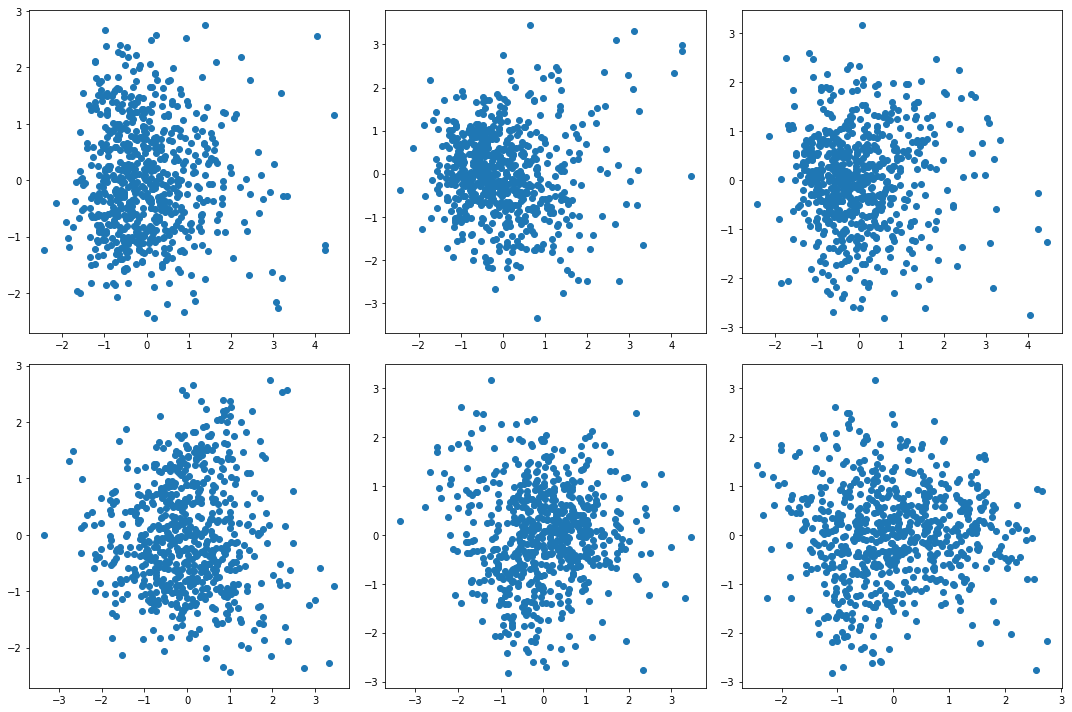

In [32]:
fig, ax = plt.subplots(2,3)
fig.set_figwidth(15)
fig.set_figheight(10)

plt.subplot(2,3,1)
plt.scatter(ws_df["watching"], ws_df["dropped"])
plt.subplot(2,3,2)
plt.scatter(ws_df["watching"], ws_df["plan_to_watch"])
plt.subplot(2,3,3)
plt.scatter(ws_df["watching"], ws_df["favorites"])
plt.subplot(2,3,4)
plt.scatter(ws_df["plan_to_watch"], ws_df["dropped"])
plt.subplot(2,3,5)
plt.scatter(ws_df["plan_to_watch"], ws_df["favorites"])
plt.subplot(2,3,6)
plt.scatter(ws_df["dropped"], ws_df["favorites"])
plt.tight_layout()

In [33]:
train_X["dropped"] = whitened_stats[:,0]
train_X["watching"] = whitened_stats[:,1]
train_X["plan_to_watch"] = whitened_stats[:,2]
train_X["favorites"] = whitened_stats[:,3]

In [34]:
train_X.head()

,mal_id,title_english,dropped,favorites,plan_to_watch,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_Very_Popular,is_Popular,is_Unpopular,is_Very_Unpopular,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,sv_0,sv_1,sv_2,sv_3,sv_4,sv_5,sv_6,sv_7,sv_8,sv_9,sv_10,sv_11,sv_12,sv_13,sv_14,sv_15,sv_16,sv_17,sv_18,sv_19,sv_20,sv_21,sv_22,sv_23,sv_24,sv_25,sv_26,sv_27,sv_28,sv_29,sv_30,sv_31,sv_32,sv_33,sv_34,sv_35,sv_36,sv_37,sv_38,sv_39,sv_40,sv_41,sv_42,sv_43,sv_44,sv_45,sv_46,sv_47,sv_48,sv_49,sv_50,sv_51,sv_52,sv_53,sv_54,sv_55,sv_56,sv_57,sv_58,sv_59,sv_60,sv_61,sv_62,sv_63,sv_64,sv_65,sv_66,sv_67,sv_68,sv_69,sv_70,sv_71,sv_72,sv_73,sv_74,sv_75,sv_76,sv_77,sv_78,sv_79,sv_80,sv_81,sv_82,sv_83,sv_84,sv_85,sv_86,sv_87,sv_88,sv_89,sv_90,sv_91,sv_92,sv_93,sv_94,sv_95,sv_96,sv_97,sv_98,sv_99,sv_100,sv_101,sv_102,sv_103,sv_104,sv_105,sv_106,sv_107,sv_108,sv_109,sv_110,sv_111,sv_112,sv_113,sv_114,sv_115,sv_116,sv_117,sv_118,sv_119,sv_120,sv_121,sv_122,sv_123,sv_124,sv_125,sv_126,sv_127,sv_128,sv_129,sv_130,sv_131,sv_132,sv_133,sv_134,sv_135,sv_136,sv_137,sv_138,sv_139,sv_140,sv_141,sv_142,sv_143,sv_144,sv_145,sv_146,sv_147,sv_148,sv_149,sv_150,sv_151,sv_152,sv_153,sv_154,sv_155,sv_156,sv_157,sv_158,sv_159,sv_160,sv_161,sv_162,sv_163,sv_164,sv_165,sv_166,sv_167,sv_168,sv_169,sv_170,sv_171,sv_172,sv_173,sv_174,sv_175,sv_176,sv_177,sv_178,sv_179,sv_180,sv_181,sv_182,sv_183,sv_184,sv_185,sv_186,sv_187,sv_188,sv_189,sv_190,sv_191,sv_192,sv_193,sv_194,sv_195,sv_196,sv_197,sv_198,sv_199,sv_200,sv_201,sv_202,sv_203,sv_204,sv_205,sv_206,sv_207,sv_208,sv_209,sv_210,sv_211,sv_212,sv_213,sv_214,sv_215,sv_216,sv_217,sv_218,sv_219,sv_220,sv_221,sv_222,sv_223,sv_224,sv_225,sv_226,sv_227,sv_228,sv_229,sv_230,sv_231,sv_232,sv_233,sv_234,sv_235,sv_236,sv_237,sv_238,sv_239,sv_240,sv_241,sv_242,sv_243,sv_244,sv_245,sv_246,sv_247,sv_248,sv_249,sv_250,sv_251,sv_252,sv_253,sv_254,sv_255,sv_256,sv_257,sv_258,sv_259,sv_260,sv_261,sv_262,sv_263,sv_264,sv_265,sv_266,sv_267,sv_268,sv_269,sv_270,sv_271,sv_272,sv_273,sv_274,sv_275,sv_276,sv_277,sv_278,sv_279,sv_280,sv_281,sv_282,sv_283,sv_284,sv_285,sv_286,sv_287,sv_288,sv_289,sv_290,sv_291,sv_292,sv_293,sv_294,sv_295,sv_296,sv_297,sv_298,sv_299
790,5630,Eden of The East,0.857602,-1.569807,-0.365276,1.066136,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,-0.049758,0.070097,-0.013160,0.029296,-0.044146,-0.044970,-0.055462,-0.023865,-0.003372,2.051685,-0.020228,-0.062936,-0.058681,-0.017387,-0.049538,0.010696,-0.042397,0.617382,-0.002686,0.032320,-0.018845,-0.044057,-0.024150,0.020822,0.002409,0.045144,0.041674,-0.032702,-0.009256,0.032120,-0.046420,-0.033880,-0.108927,0.011874,0.041124,0.044727,0.086923,0.000375,0.020178,0.002146,0.012383,-0.082690,0.125003,0.057947,-0.035477,0.053562,-0.066956,0.008789,0.026393,-0.055111,-0.094816,-0.000699,-0.090763,-0.048135,-0.054672,0.042932,0.019006,-0.103644,0.069593,-0.074405,-0.002536,-0.075918,0.020236,-0.134388,0.036675,-0.059457,-0.056521,0.088512,0.037646,0.011802,0.010475,-0.021126,0.013673,-0.025007,0.023995,-0.058334,0.038847,-0.115593,-0.011587,0.172999,0.019613,0.038611,-0.122097,-0.004023,0.039357,-0.131059,0.106670,-0.182603,0.019326,0.028611,-0.086143,0.122741,-0.144791,-0.003019,-0.014749,-0.042550,0.010953,-0.084592,-0.058311,0.043956,-0.026148,0.030212,0.020539,-0.070896,0.073315,-0.964839,-0.101054,0.114312,0.027857,0.059342,0.116553,0.025719,-0.004239,-0.077048,-0.053274,0.072610,0.050920,0.103574,-0.000879,-0.013368,-0.045377,-0.056739,0.009959,0.031102,0.121459,0.057266,-0.022258,-0.017304,-0.027942,0.038878,0.013859,-0.022585,0.033855,0.076539,0.006

In [35]:
# Transform test set
transformed_stats = power_transformer.transform(test_X[stats])
whitened_stats = pca.transform(transformed_stats)

In [36]:
test_X["dropped"] = whitened_stats[:,0]
test_X["watching"] = whitened_stats[:,1]
test_X["plan_to_watch"] = whitened_stats[:,2]
test_X["favorites"] = whitened_stats[:,3]

In [37]:
test_X.head()

,mal_id,title_english,dropped,favorites,plan_to_watch,watching,season_Fall,season_Spring,season_Summer,season_Winter,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_Very_Popular,is_Popular,is_Unpopular,is_Very_Unpopular,has_Prequel,has_Sequel,is_Light novel,is_Manga,is_Original,is_Visual novel,is_Action,is_Adventure,is_Comedy,is_Drama,is_Ecchi,is_Fantasy,is_Harem,is_Josei,is_Mystery,is_Romance,is_School,is_Sci-Fi,is_Seinen,is_Shoujo,is_Shounen,is_Slice of Life,is_Supernatural,sv_0,sv_1,sv_2,sv_3,sv_4,sv_5,sv_6,sv_7,sv_8,sv_9,sv_10,sv_11,sv_12,sv_13,sv_14,sv_15,sv_16,sv_17,sv_18,sv_19,sv_20,sv_21,sv_22,sv_23,sv_24,sv_25,sv_26,sv_27,sv_28,sv_29,sv_30,sv_31,sv_32,sv_33,sv_34,sv_35,sv_36,sv_37,sv_38,sv_39,sv_40,sv_41,sv_42,sv_43,sv_44,sv_45,sv_46,sv_47,sv_48,sv_49,sv_50,sv_51,sv_52,sv_53,sv_54,sv_55,sv_56,sv_57,sv_58,sv_59,sv_60,sv_61,sv_62,sv_63,sv_64,sv_65,sv_66,sv_67,sv_68,sv_69,sv_70,sv_71,sv_72,sv_73,sv_74,sv_75,sv_76,sv_77,sv_78,sv_79,sv_80,sv_81,sv_82,sv_83,sv_84,sv_85,sv_86,sv_87,sv_88,sv_89,sv_90,sv_91,sv_92,sv_93,sv_94,sv_95,sv_96,sv_97,sv_98,sv_99,sv_100,sv_101,sv_102,sv_103,sv_104,sv_105,sv_106,sv_107,sv_108,sv_109,sv_110,sv_111,sv_112,sv_113,sv_114,sv_115,sv_116,sv_117,sv_118,sv_119,sv_120,sv_121,sv_122,sv_123,sv_124,sv_125,sv_126,sv_127,sv_128,sv_129,sv_130,sv_131,sv_132,sv_133,sv_134,sv_135,sv_136,sv_137,sv_138,sv_139,sv_140,sv_141,sv_142,sv_143,sv_144,sv_145,sv_146,sv_147,sv_148,sv_149,sv_150,sv_151,sv_152,sv_153,sv_154,sv_155,sv_156,sv_157,sv_158,sv_159,sv_160,sv_161,sv_162,sv_163,sv_164,sv_165,sv_166,sv_167,sv_168,sv_169,sv_170,sv_171,sv_172,sv_173,sv_174,sv_175,sv_176,sv_177,sv_178,sv_179,sv_180,sv_181,sv_182,sv_183,sv_184,sv_185,sv_186,sv_187,sv_188,sv_189,sv_190,sv_191,sv_192,sv_193,sv_194,sv_195,sv_196,sv_197,sv_198,sv_199,sv_200,sv_201,sv_202,sv_203,sv_204,sv_205,sv_206,sv_207,sv_208,sv_209,sv_210,sv_211,sv_212,sv_213,sv_214,sv_215,sv_216,sv_217,sv_218,sv_219,sv_220,sv_221,sv_222,sv_223,sv_224,sv_225,sv_226,sv_227,sv_228,sv_229,sv_230,sv_231,sv_232,sv_233,sv_234,sv_235,sv_236,sv_237,sv_238,sv_239,sv_240,sv_241,sv_242,sv_243,sv_244,sv_245,sv_246,sv_247,sv_248,sv_249,sv_250,sv_251,sv_252,sv_253,sv_254,sv_255,sv_256,sv_257,sv_258,sv_259,sv_260,sv_261,sv_262,sv_263,sv_264,sv_265,sv_266,sv_267,sv_268,sv_269,sv_270,sv_271,sv_272,sv_273,sv_274,sv_275,sv_276,sv_277,sv_278,sv_279,sv_280,sv_281,sv_282,sv_283,sv_284,sv_285,sv_286,sv_287,sv_288,sv_289,sv_290,sv_291,sv_292,sv_293,sv_294,sv_295,sv_296,sv_297,sv_298,sv_299
274,21033,Dragonar Academy,-0.934413,-0.065920,-0.563854,-1.086677,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,-0.058609,0.027730,-0.097004,-0.080735,-0.001361,-0.019610,-0.022125,-0.030257,-0.074432,2.022782,-0.123717,-0.068031,-0.124491,-0.043650,-0.044567,0.069401,0.002779,0.752130,-0.065495,0.005732,-0.041421,-0.084440,-0.196654,-0.030356,0.033092,0.030520,-0.057989,-0.027396,-0.011230,0.005631,-0.134233,0.055166,-0.021729,-0.044957,0.062638,0.071811,0.044290,0.081129,-0.023306,-0.067561,0.071252,-0.063216,0.058478,0.048505,0.125128,0.042113,-0.087989,-0.014796,0.011756,-0.116416,-0.185245,-0.006368,0.003004,0.017745,-0.014172,0.043187,-0.050993,-0.011551,-0.028271,-0.070064,-0.031425,-0.105045,0.028959,0.038231,0.027707,0.018160,-0.060111,0.084877,0.055696,0.104418,-0.080875,-0.124527,0.007943,-0.046660,-0.008744,0.160916,0.074064,-0.036274,0.013363,0.100655,-0.038601,0.052845,-0.078782,0.071096,0.050056,-0.178791,0.186769,-0.000127,-0.005768,0.073112,-0.090394,0.057106,-0.069727,-0.103706,0.068661,-0.116834,0.066339,-0.017091,0.003132,0.081553,0.060966,0.013549,-0.045870,-0.056706,-0.086825,-0.841758,-0.067455,0.098718,0.079053,-0.035376,-0.015963,-0.068772,0.072507,-0.070720,0.013431,0.006303,0.024558,0.072692,-0.029528,-0.045336,-0.030133,-0.067292,0.144428,0.012616,0.036454,0.031358,-0.001145,-0.046396,-0.074378,-0.022152,0.000613,-0.058218,0.072621,-0.0341

In [42]:
train_X.to_hdf("data/processed_synopsis/train_X", "table")
train_Y.to_hdf("data/processed_synopsis/train_Y", "table")
test_X.to_hdf("data/processed_synopsis/test_X", "table")
test_Y.to_hdf("data/processed_synopsis/test_Y", "table")